,city,x,y
0,San Francisco,5.513656e+05,4.181936e+06
1,Los Angeles,9.385837e+05,3.777893e+06
2,Oklahoma City,2.833852e+06,4.239858e+06
3,Dallas,2.988069e+06,3.949013e+06
4,Detroit,3.798415e+06,5.533473e+06
5,Miami,5.045288e+06,3.693890e+06
6,New York City,4.676500e+06,5.844604e+06


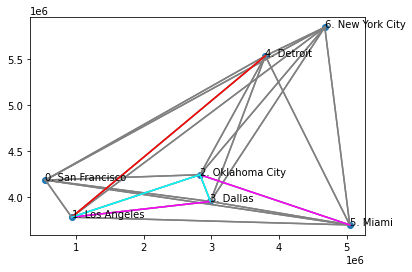

In [1]:
from IPython.core.display_functions import display
from containers.cities import CitiesGraph

path = "data/cities.csv"
graph = CitiesGraph.from_file(path, [
    "Dallas",
    "Detroit",
    "Los Angeles",
    "Miami",
    "New York City",
    "Oklahoma City",
    "San Francisco",
])
display(graph.cities.coords)
graph.fully_connect()
graph.plot_cities(with_index=True)
graph.plot_connections(color="grey")
graph.plot_segment(1, 4, color='r')
graph.plot_segments([(1, 3), (2, 5)], color='magenta')
graph.plot_line([1, 2, 3], color='cyan')

In [2]:
from utils.timeit import timeit
from typing import Container, Dict, List, Optional, Tuple


Costs = Dict[Tuple[int, int], float]
Sequence = List[int]
Links = Container[Tuple[int, int]]


def link_exists(link: Tuple[int, int], links: Optional[Links]) -> bool:
    return (links is None) or (link in links)


def list_permutations(
        nodes: List[int],
        links: Optional[Links] = None,
) -> List[Sequence]:
    """Return all possible permutations of nodes"""
    if len(nodes) == 1:
        return [nodes]

    permutations = []
    for i, item in enumerate(nodes):
        sub_nodes = nodes.copy()
        sub_nodes.pop(i)
        sub_permutations = list_permutations(sub_nodes, links=links)
        for sub_permutation in sub_permutations:
            if not link_exists((item, sub_permutation[0]), links):
                continue
            permutations.append([item] + sub_permutation)
    return permutations


def list_circles(
        nodes: List[int],
        start_index: int = 0,
        links: Optional[Links] = None,
) -> List[Sequence]:
    """Return list of closed chains going through every nodes"""
    if len(nodes) == 1:
        return [nodes]

    inner_nodes = nodes.copy()
    start = inner_nodes.pop(start_index)
    inner_permutations = list_permutations(inner_nodes, links=links)
    return [
        [start] + permutation + [start]
        for permutation in inner_permutations
        if (
            link_exists((start, permutation[0]), links)
            and link_exists((permutation[-1], start), links)
        )
    ]


def compute_sequence_cost(sequence: Sequence, costs: Costs) -> float:
    """Evaluate a sequence given costs

    Args:
        sequence: chain of nodes
        costs   : the costs of going from one node to another

    Returns:
        Total cost to go through sequence

    Raises:
        KeyError: when there is no link between 2 nodes
    """
    if len(sequence) <= 1:
        return 0
    return sum([
        costs[(start, end)] if start != end else 0
        for start, end in zip(sequence[:-1], sequence[1:])
    ])


def get_cheapest_sequence(sequences: List[Sequence], costs: Costs) -> float:
    """Return sequence with the minimum cost"""
    best = None
    best_cost = None
    for sequence in sequences:
        cost = compute_sequence_cost(sequence, costs)
        if (best_cost is None) or (cost < best_cost):
            best = sequence
            best_cost = cost
    return best


@timeit
def find_best_path(graph: CitiesGraph, plot: bool = True) -> Sequence:
    """Find best path to go through all cities of graph in a closed circle"""
    nodes = graph.get_nodes()
    costs = graph.get_distances_by_segments()
    sequences = list_circles(nodes, links=costs)
    best_sequence = get_cheapest_sequence(sequences, costs=costs)
    if plot:
        graph.plot_cities(with_index=True)
        graph.plot_connections(color="grey")
        graph.plot_line(best_sequence, color='cyan')
        plt.gca().set_aspect('equal', adjustable='box')
    return best_sequence

assert len(list_permutations(graph.get_nodes())) == 5040

'find_best_path' run took 0.02650s [7 items]


[0, 1, 2, 3, 5, 6, 4, 0]

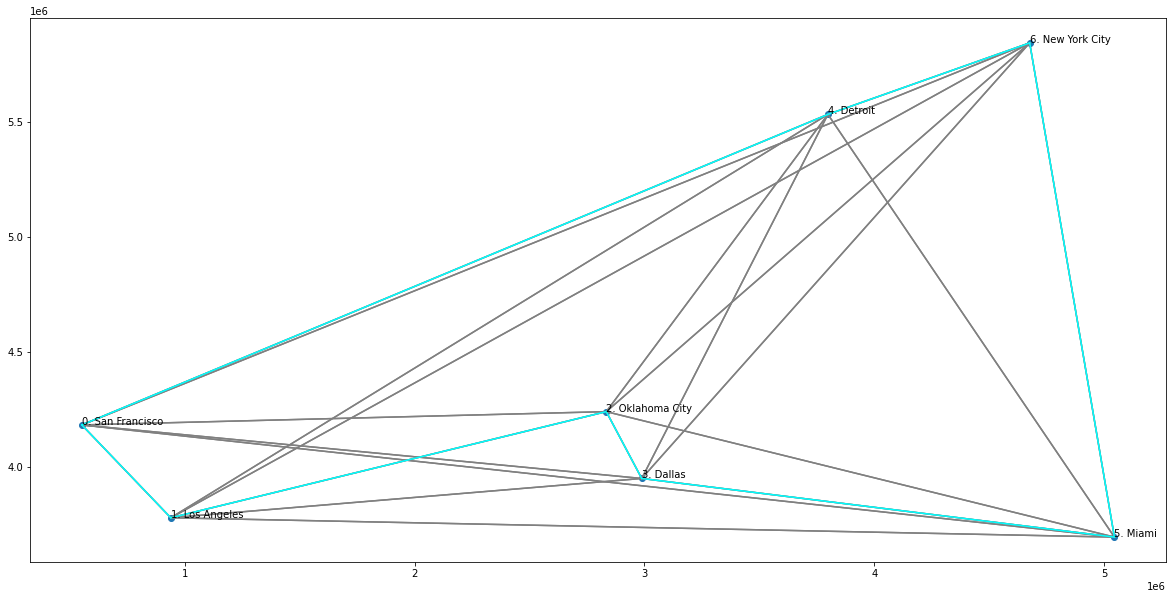

In [3]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [30, 10]

graph.fully_connect()
find_best_path(graph)

'find_best_path' run took 0.02164s [7 items]


[0, 1, 3, 5, 6, 4, 2, 0]

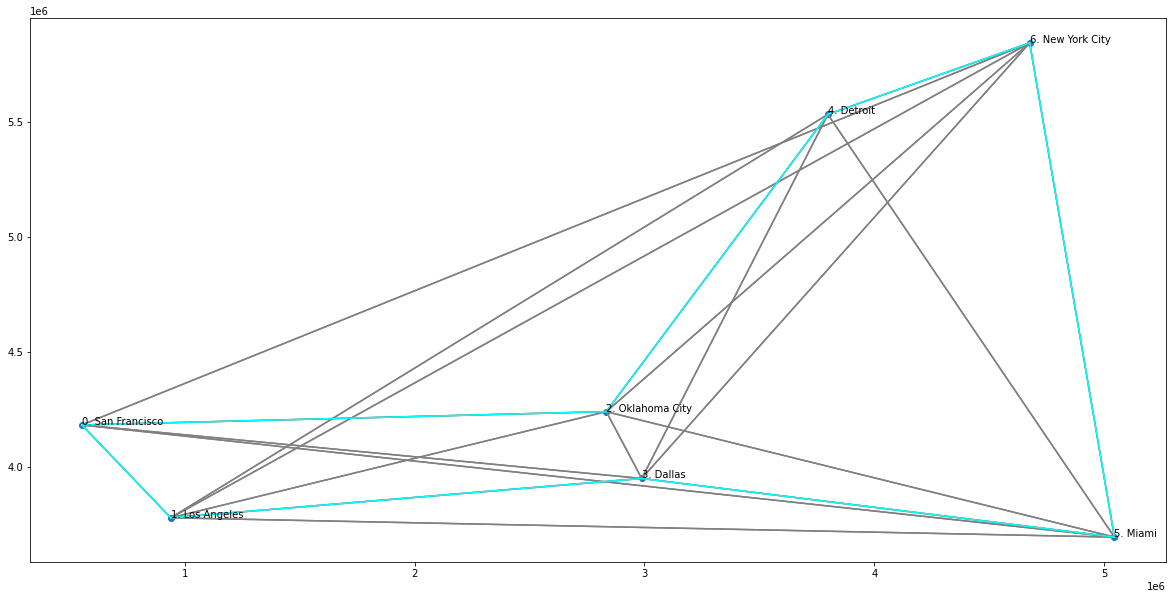

In [4]:
from containers.cities import Connection

graph.fully_connect()
graph.connections.remove(Connection(0, 4, -1))
graph.connections.remove(Connection(4, 0, -1))
find_best_path(graph)